In [11]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import re
import requests
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
import json


Datasets:

Victims of fatal encounters with the police, from mappingpoliceviolence.org (MPV), that includes similar features and information to the Washington Post dataset, but additionally lists the police department involved and includes fatal encounters where the cause of death was not shooting. 

The election 2016 demographic data that we analyzed in HW1 (we may replace this with official cenus data, but for an initial exploratory data analysis this dataste is clean and we are somewhat familiar with it)

LEMAS police department survey (). This includes a wide variety of information on the demographics and policies of individual police deparments. 



In [65]:
# load wapo
wapo_df = pd.read_csv('./data/fatal-police-shootings-data.csv')

# load MPV data
mpv_df = pd.read_excel(pd.ExcelFile('data/MPVDatasetDownload_CleanColumnNames.xlsx'), sheet_name='2013-2020 Police Killings')

# load county-wise demographic info from US census
county_df = pd.read_csv('data/acs2015_county_data.csv')

# load election data from HW 1
election_county_df = pd.read_csv('data/election2016_by_county.csv')

# load LEMAS
lemas_raw = pd.read_csv('data/LEMAS_2016.tsv', sep = '\t', index_col = 'LEAR_ID', header = 0, encoding = 'unicode_escape')

In [80]:
wapo_df.head()


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,wapo_id
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,3
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,4
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,5
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,8
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,9


In [68]:
# create FIPS code column for merging
df_demo['FIPS'] = df_demo.CensusId
df_election['FIPS'] = df_election.fipscode




Index(['AGENCYNAME', 'CITY', 'ZIPCODE', 'STATE', 'COUNTY', 'FIPS', 'ORI9',
       'POPSERVED', 'POPGROUP', 'AGENCYTYPE',
       ...
       'NEW_TOT_HIRES', 'NEW_TOT_SEP', 'FINALWGT_NTH_NTS', 'FLAG1', 'FLAG2',
       'FLAG3', 'FLAG4', 'FLAG5', 'FLAG6', 'FLAG7'],
      dtype='object', length=433)

In [59]:
xls = pd.ExcelFile('data/MPVDatasetDownload_CleanColumnNames.xlsx')
#ew is event-wise 
df = pd.read_excel(xls, sheet_name='2013-2020 Police Killings')
killings_by_pd = pd.read_excel(xls,sheet_name='2013-2019 Killings by PD')
killings_by_state = pd.read_excel(xls,sheet_name='2013-2019 Killings by State')

df.head()

,victim_name,victim_age,victim_gender,victim_race,image_of_victim,date,street_address,city,state_code,zipcode,...,armed,weapon,threat_level,fleeing,body_camera,wapo_id,off_duty,geography,MPV_ID,fatal_encounters_id
0,Bennie Biby,44,Male,Unknown race,NaN,2020-10-28,NaN,Trigg County,KY,NaN,...,Allegedly Armed,undetermined,undetermined,NaN,No,6271.0,NaN,NaN,NaN,NaN
1,Clifton Gorman Spencer,35,Male,Unknown race,NaN,2020-10-27,NaN,Chattanooga,TN,NaN,...,Allegedly Armed,gun,other,NaN,No,6269.0,NaN,NaN,NaN,NaN
2,Name withheld by police,NaN,Male,Unknown race,NaN,2020-10-27,5300 W. Solafax Lane,Herriman,UT,84096.0,...,Allegedly Armed,undetermined,undetermined,NaN,No,6268.0,NaN,Suburban,NaN,NaN
3,Michael K. Nelson,27,Male,Unknown race,NaN,2020-10-26,NaN,Alexandria,VA,NaN,...,Allegedly Armed,gun,attack,foot,No,6270.0,NaN,NaN,NaN,NaN
4,Walter Wallace Jr.,27,Male,Black,NaN,2020-10-26,NaN,Philadelphia,PA,NaN,...,Allegedly Armed,knife,other,not fleeing,No,6266.0,NaN,NaN,NaN,NaN


In [16]:
# convert the date to datetime
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))


In [18]:
# load more data 



race_fields = ['WHITE','BLACK','HISP','AMIND','ASIAN','HAWPI','MULTI','UNK']
gender_fields = ['MALE','FEM']

# remove rows that do not have demographic info
lemas_raw = lemas_raw.loc[(lemas_raw.PERS_MALE>=0) & (lemas_raw.PERS_FEMALE>=0) & (lemas_raw.PERS_WHITE_FEM>=0) & (lemas_raw.PERS_WHITE_MALE>=0)]


lemas_raw['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE

# for now, take a fraction of the columns or it is overwhelming...
# EDIT:
lemas_new = lemas_raw.iloc[:,0:10]



lemas_new['PERS_TOTAL'] = lemas_raw.PERS_MALE + lemas_raw.PERS_FEMALE
lemas_new['PERS_WHITE'] = lemas_raw.PERS_WHITE_MALE + lemas_raw.PERS_WHITE_FEM
lemas_new['FRAC_WHITE'] = lemas_new.PERS_WHITE/lemas_new.PERS_TOTAL

# create FIPS code column for merging
df_demo['FIPS'] = df_demo.CensusId
df_election['FIPS'] = df_election.fipscode
df_election = df_election[['FIPS','trump','clinton','votergap','density']]

# make LEMAS FIPS CODE NUMERIC
lemas_new.FIPS = pd.to_numeric(lemas_new.FIPS,errors='coerce')
lemas_new = lemas_new.dropna()

# REMOVE STATE AGENCIES FOR NOW BECAUSE DEMOGRAPHICS HAVE NOT BEEN COMPUTED ON STATE-WIDE LEVEL
# Also, only 18 state agencies have had shooting victims, and count is relatively low, so we are not excluding a huge amount of useful data

lemas_new = lemas_new[lemas_new.AGENCYTYPE<3]

# merge county-level voter and demographic data into lemas new

lemas_new = lemas_new.merge(df_demo,how='left',on='FIPS')
lemas_new = lemas_new.merge(df_election,how='left',on='FIPS')

# for every police department, compute victim stats

vic_stats_all = []

for ind,row in lemas_new.iterrows():
    ori_id = row['ORI9']
    # find victims
    vic = df[df.ORI_agency_id==ori_id]
    vic_stats = get_victim_stats(vic)
    vic_stats['ORI9'] = ori_id
    vic_stats_all.append(vic_stats)

pd_vic_stats = pd.DataFrame(vic_stats_all)

lemas_new = lemas_new.merge(pd_vic_stats,how='left',on='ORI9')



print(f'fraction of police departments (not state-level) responsible for at least one fatality: {(pd_vic_stats.n_victims>0).mul(1).mean():.4f}')


print('Statistics for victims of police departments, for police departments with at least 1 shooting:')
# look at stats for only police departments with at least one shooting / killing
pd_vic_stats[pd_vic_stats.n_victims>0].describe()


C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\Noah Petit\.conda\envs\cs109a\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in longlong_scalars


fraction of police departments (not state-level) responsible for at least one fatality: 0.3253
Statistics for victims of police departments, for police departments with at least 1 shooting:


,n_victims,n_unarmed,n_armed,n_white,n_black,n_hispanic,mean_age,frac_unarmed,frac_white,frac_black,frac_hispanic
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,817.000000,827.000000,827.000000,827.000000,827.000000
mean,5.302297,0.787183,3.830713,1.827086,1.662636,1.094317,36.890885,0.145968,0.468109,0.252349,0.140668
std,10.092216,1.752392,7.477675,2.743752,4.471984,4.163813,9.772811,0.262183,0.403163,0.343915,0.265087
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,35.843750,0.000000,0.428571,0.000000,0.000000
75%,5.000000,1.000000,4.000000,2.000000,1.000000,1.000000,41.294118,0.200000,1.000000,0.500000,0.174797
max,132.000000,22.000000,103.000000,31.000000,58.000000,76.000000,76.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
print('Police departments with at least 10 victims, sorted by fraction of victims that are unarmed (top 10 shown):')

lemas_new[lemas_new.n_victims>=10].sort_values('frac_unarmed',ascending=False).head(10)

Police departments with at least 10 victims, sorted by fraction of victims that are unarmed (top 10 shown):


,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,ORI9,POPSERVED,POPGROUP,AGENCYTYPE,...,n_unarmed,n_armed,n_white,n_black,n_hispanic,mean_age,frac_unarmed,frac_white,frac_black,frac_hispanic
553,CLEVELAND POLICE DEPARTMENT,CLEVELAND,44113,OH,CUYAHOGA,39035.0,OHCLP0000,385809,3,1,...,5,5,1,10,0,29.818182,0.454545,0.090909,0.909091,0.000000
2554,PRINCE GEORGES COUNTY POLICE,HYATTSVILLE,20785,MD,PRINCE GEORGE'S,24033.0,MD0172100,693100,2,1,...,5,9,0,13,1,30.714286,0.357143,0.000000,0.928571,0.071429
2571,SAN DIEGO COUNTY SHERIFF'S OFFICE,SAN DIEGO,92193,CA,SAN DIEGO,6073.0,CA0370000,3317749,1,2,...,7,10,6,2,10,37.722222,0.350000,0.300000,0.100000,0.500000
2569,ATLANTA POLICE DEPARTMENT,ATLANTA,30303,GA,FULTON,13121.0,GAAPD0000,439856,3,1,...,6,10,1,16,0,29.764706,0.333333,0.055556,0.888889,0.000000
2539,PASCO COUNTY SHERIFF'S OFFICE,NEW PORT RICHEY,34654,FL,PASCO,12101.0,FL0510000,512368,2,2,...,4,6,9,2,0,43.181818,0.333333,0.750000,0.166667,0.000000
2551,FRESNO POLICE DEPARTMENT,FRESNO,93721,CA,FRESNO,6019.0,CA0100500,522053,2,1,...,8,18,5,1,16,34.520000,0.307692,0.192308,0.038462,0.615385
2316,ARLINGTON POLICE DEPARTMENT,ARLINGTON,76011,TX,,48439.0,TX2200100,392772,3,1,...,4,7,3,7,1,29.666667,0.307692,0.230769,0.538462,0.076923
2469,SACRAMENTO POLICE DEPARTMENT,SACRAMENTO,95822,CA,SACRAMENTO,6067.0,CA0340400,495234,3,1,...,4,9,6,6,1,36.428571,0.285714,0.428571,0.428571,0.071429
2385,ANAHEIM POLICE DEPARTMENT,ANAHEIM,92803,CA,ORANGE,6059.0,CA0300100,351043,3,1,...,4,7,3,3,8,31.714286,0.285714,0.214286,0.214286,0.571429
2197,BILLINGS POLICE DEPARTMENT,BILLINGS,59103,MT,YELLOWSTONE,30111.0,MT0560100,110323,4,1,...,3,6,7,0,1,31.400000,0.272727,0.636364,0.000000,0.090909


Text(0.5, 1.0, 'Each point is a police department responsible for at least 10 victims')

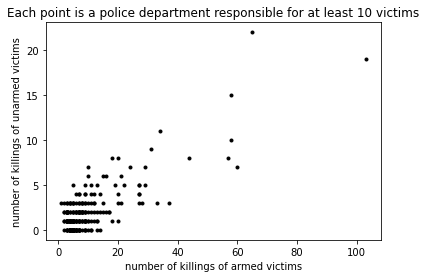

In [38]:
include = lemas_new.n_victims>=5

plt.plot(lemas_new.n_armed[include], lemas_new.n_unarmed[include],'k.')
plt.xlabel('number of killings of armed victims')
plt.ylabel('number of killings of unarmed victims')
plt.title('Each point is a police department responsible for at least 10 victims')

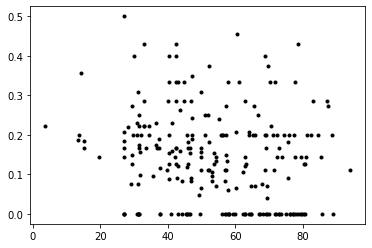

In [45]:
include = lemas_new.n_victims>=5

unarmed_ratio = lemas_new.n_unarmed[include]/lemas_new.n_victims[include]

plt.plot(lemas_new.White[include],unarmed_ratio,'k.')

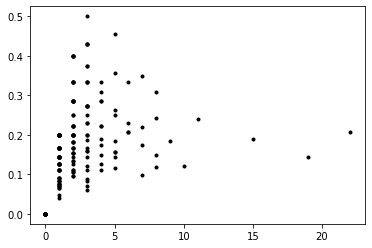

In [47]:
plt.plot(lemas_new.n_unarmed[include],unarmed_ratio,'k.')

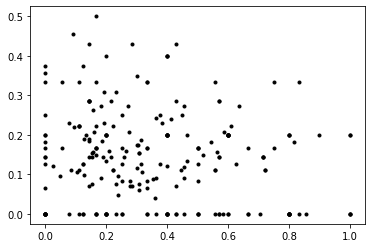

In [53]:
frac_white_vic = lemas_new.frac_white[include]
plt.plot(frac_white_vic,unarmed_ratio,'k.')

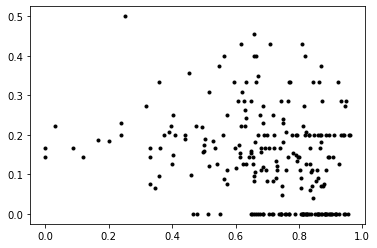

In [52]:
frac_white_off = lemas_new.FRAC_WHITE[include]
plt.plot(frac_white_off,unarmed_ratio,'k.')

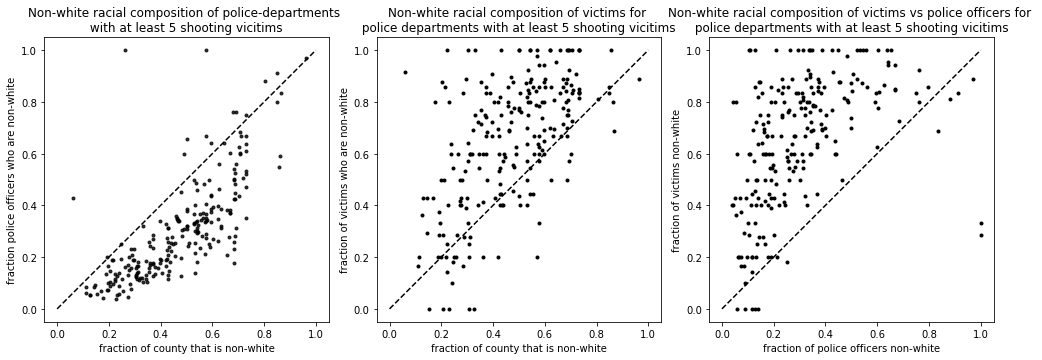

In [30]:
include = lemas_new.n_victims>=5


fig, ax = plt.subplots(1,3,figsize=(14, 5))
ax = ax.flatten()

ax[0].plot(1-(lemas_new.White[include]/100), 1-lemas_new.FRAC_WHITE[include],'k.',color='black',alpha=0.8)
ax[0].set(xlabel= 'fraction of county that is non-white',ylabel='fraction police officers who are non-white',aspect='equal',
          title='Non-white racial composition of police-departments \n with at least 5 shooting vicitims ')
ax[0].plot([0,1],[0,1],'k--', color='black')


ax[1].plot(1-lemas_new.White[include]/100, 1-lemas_new.frac_white[include],'k.')
ax[1].set(xlabel= 'fraction of county that is non-white',ylabel='fraction of victims who are non-white',aspect='equal',
         title='Non-white racial composition of victims for \n police departments with at least 5 shooting vicitims ')
ax[1].plot([0,1],[0,1],'k--', color='black')

ax[2].plot(1-lemas_new.FRAC_WHITE[include], 1-lemas_new.frac_white[include],'k.')
ax[2].set(xlabel= 'fraction of police officers non-white',ylabel='fraction of victims non-white', aspect='equal',
         title='Non-white racial composition of victims vs police officers for \n police departments with at least 5 shooting vicitims ')
ax[2].plot([0,1],[0,1],'k--', color='black')


plt.tight_layout()
plt.savefig('race_pd_vic_scatter.pdf',dpi=300)


In [23]:
np.mean((lemas_new.White[include]/100))
#np.mean(lemas_new.FRAC_WHITE[include])

0.5319957081545064

In [25]:
log_odds_frac_white = np.log((1-lemas_new.frac_white[include])/(1-(lemas_new.White[include]/100)))
(1-(lemas_new.White[include]/100))

25      0.360
33      0.706
34      0.360
35      0.204
36      0.061
        ...  
2579    0.542
2580    0.731
2581    0.569
2582    0.731
2583    0.529
Name: White, Length: 233, dtype: float64

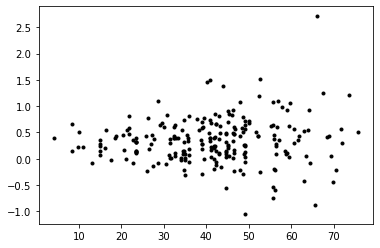

In [26]:
plt.plot(lemas_new.trump[include],log_odds_frac_white,'k.')

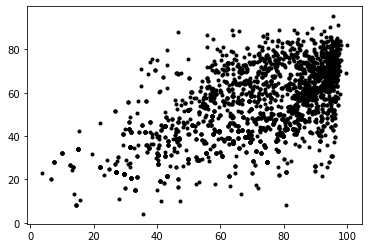

In [27]:
plt.plot(lemas_new.White, lemas_new.trump,'k.')
plt.plot()

In [37]:
lemas_new.columns

Index(['AGENCYNAME', 'CITY', 'ZIPCODE', 'STATE', 'COUNTY', 'FIPS', 'ORI9',
       'POPSERVED', 'POPGROUP', 'AGENCYTYPE', 'PERS_TOTAL', 'PERS_WHITE',
       'FRAC_WHITE', 'CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment', 'trump', 'clinton',
       'votergap', 'density', 'n_victims', 'n_unarmed', 'n_armed', 'n_white',
       'n_black', 'n_hispanic', 'mean_age', 'frac_unarmed', 'frac_white',
       'frac_black', 'frac_hispanic'],
      dtype='object')